# Cluster Countries by Democracy Datasets

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import sklearn as sk
from scipy.cluster.hierarchy import dendrogram
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geodatasets

In [54]:
# Democracy
freedom_world_df = pd.read_csv('../datasets/processed/democracy/freedom-world/freedom-world-snapshot.csv', header=0)
lied_df = pd.read_csv('../datasets/processed/democracy/lied/lied-snapshot.csv', header=0)
polity_df = pd.read_csv('../datasets/processed/democracy/polity/polity5-snapshot.csv', header=0)

In [55]:
print(freedom_world_df.info())
print(lied_df.info())
print(polity_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 40 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   iso3       195 non-null    object
 1   country    195 non-null    object
 2   status     195 non-null    object
 3   pr_rating  195 non-null    int64 
 4   cl_rating  195 non-null    int64 
 5   a1         195 non-null    int64 
 6   a2         195 non-null    int64 
 7   a3         195 non-null    int64 
 8   a          195 non-null    int64 
 9   b1         195 non-null    int64 
 10  b2         195 non-null    int64 
 11  b3         195 non-null    int64 
 12  b4         195 non-null    int64 
 13  b          195 non-null    int64 
 14  c1         195 non-null    int64 
 15  c2         195 non-null    int64 
 16  c3         195 non-null    int64 
 17  c          195 non-null    int64 
 18  pr         195 non-null    int64 
 19  d1         195 non-null    int64 
 20  d2         195 non-null    int64

In [56]:
merged_df = freedom_world_df.merge(lied_df, on='iso3', how='inner', suffixes=('_f', '_g'))
merged_df = merged_df.merge(polity_df, on='iso3', how='inner', suffixes=('_f', '_g'))

print(f"Countries in Freedom in the World: {len(freedom_world_df)}")
print(f"Countries in LIED: {len(lied_df)}")
print(f"Countries in Polity5: {len(polity_df)}")
print(f"Countries in all the datasets: {len(merged_df)}")

Countries in Freedom in the World: 195
Countries in LIED: 198
Countries in Polity5: 161
Countries in all the datasets: 162


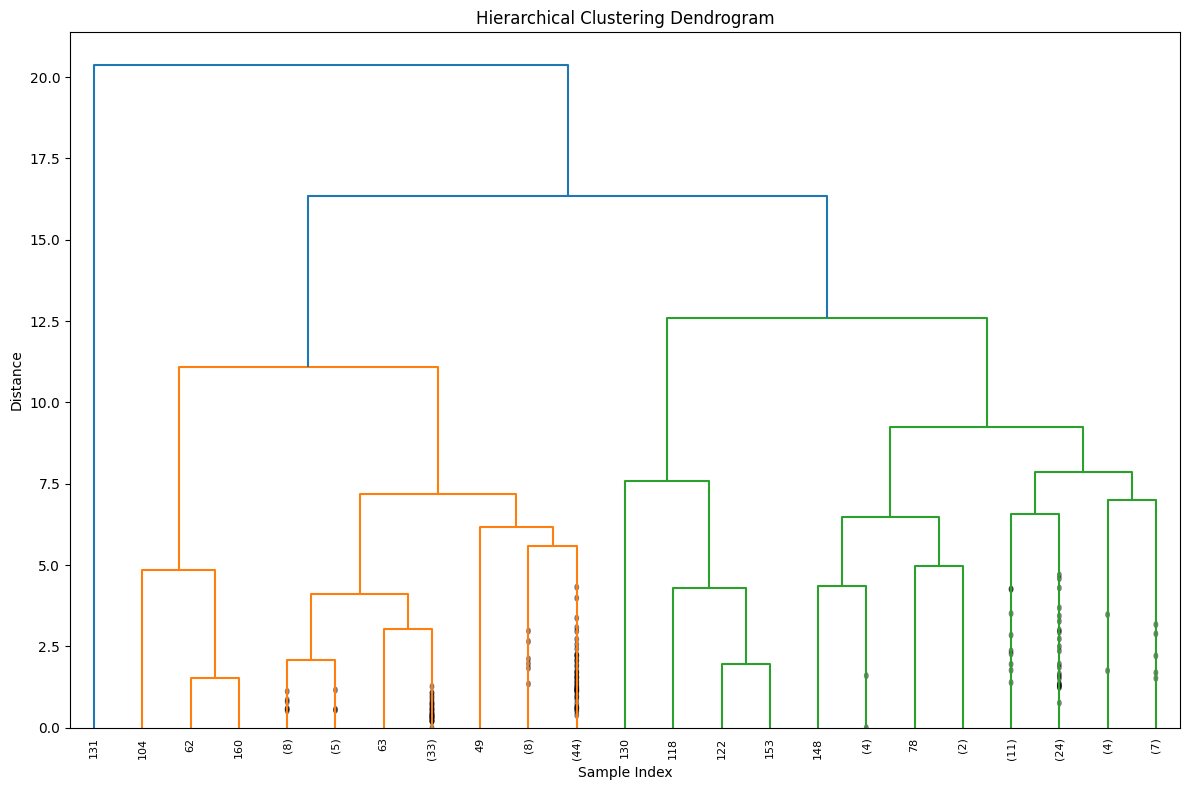

In [57]:
def compute_linkage(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)
    return linkage_matrix

predictors = ["a","b","c","d","e","f","g","male_suffrage","female_suffrage","executive_elections","legislative_elections","multi-party_legislative_elections","competitive_elections","democratic_transition",
              "transition_type","sovereign","exconst","exrec","parcomp","parreg","polcomp","xconst","xrcomp","xropen","xrreg"]

components_df = merged_df[predictors]
scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(components_df)
hc_comp_scale = sk.cluster.AgglomerativeClustering(distance_threshold=0,
                       n_clusters=None,
                       linkage='complete').fit(X_scaled)
linkage_comp_scale = compute_linkage(hc_comp_scale)

plt.figure(figsize=(12, 8))
dendrogram(linkage_comp_scale,
          truncate_mode='level',
          p=5,
          leaf_rotation=90.,
          leaf_font_size=8.,
          show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


Now I'll try to get some clusters

In [58]:
hc_comp_scale = sk.cluster.AgglomerativeClustering(distance_threshold=10,
                       n_clusters=None,
                       linkage='complete').fit(X_scaled)
cluster_labels = hc_comp_scale.labels_
cluster_df = pd.DataFrame({
    'country': merged_df['country'],
    "total": merged_df['total'],
    "iso3": merged_df['iso3'],
    'cluster': cluster_labels
})

for cluster in sorted(cluster_df['cluster'].unique()):
    countries = cluster_df[cluster_df['cluster'] == cluster][['country', 'total']].values.tolist()
    print(f"\nCluster {cluster} ({len(countries)} countries):")
    countries = [f"{country} ({total})" for country, total in countries]
    print(", ".join(countries))


Cluster 0 (54 countries):
Afghanistan (6), Algeria (31), Angola (28), Azerbaijan (7), Bahrain (12), Bangladesh (45), Belarus (7), Burundi (15), Cambodia (23), Cameroon (15), Central African Republic (5), Chad (15), China (9), Comoros (42), Congo (Brazzaville) (17), Cuba (10), Djibouti (24), Egypt (18), Equatorial Guinea (5), Eritrea (3), Eswatini (17), Ethiopia (18), Gabon (21), Guinea (30), Haiti (24), Iran (11), Jordan (34), Kazakhstan (23), Kuwait (31), Kyrgyzstan (26), Laos (13), Mali (24), Mauritania (39), Morocco (37), Myanmar (7), Nicaragua (14), North Korea (3), Oman (24), Russia (12), Rwanda (21), Singapore (48), Syria (5), Tajikistan (5), Tanzania (35), Thailand (34), Togo (41), Tunisia (44), Turkey (33), Turkmenistan (1), Uganda (34), Uzbekistan (12), Venezuela (13), Vietnam (20), Zimbabwe (26)

Cluster 1 (4 countries):
Qatar (25), Saudi Arabia (9), Somalia (8), United Arab Emirates (18)

Cluster 2 (100 countries):
Albania (68), Argentina (85), Armenia (54), Australia (95),

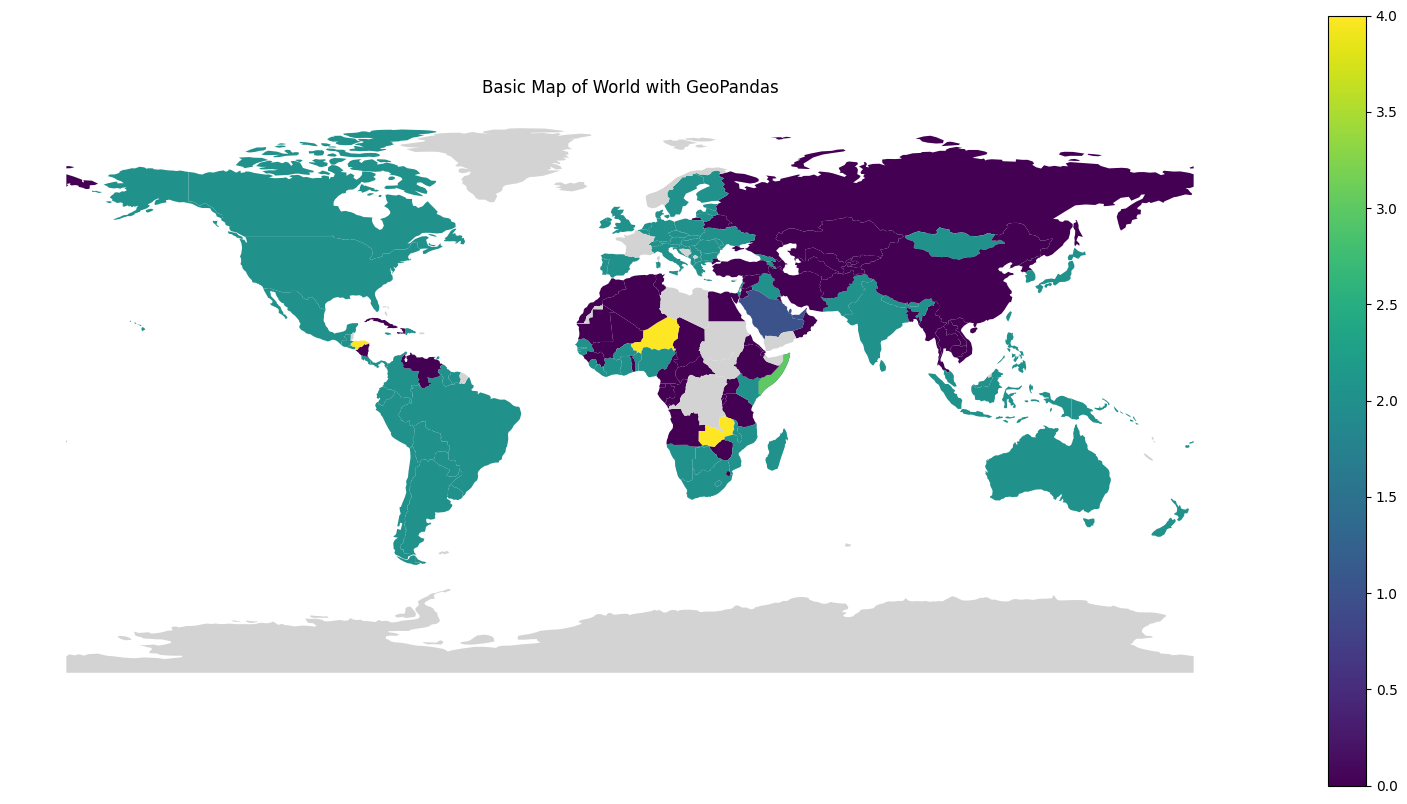

In [59]:
# load the low resolution world map
world = gpd.read_file('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson')
world = world.merge(cluster_df, left_on='ISO_A3', right_on='iso3', how='left')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
world.plot(
    column='cluster',
    ax=ax,
    legend=True,
    missing_kwds={'color': 'lightgrey'}
)

# turn off axis ticks
ax.axis('off')

# set the plot title
plt.title("Basic Map of World with GeoPandas")
plt.show()


# Clustering by Women's Rights

In [60]:
world_bank_df = pd.read_csv('../datasets/processed/women/world-bank/women-business-and-the-law-snapshot.csv', header=0)
print(world_bank_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 52 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso3                                 190 non-null    object 
 1   country                              190 non-null    object 
 2   ISO Code                             190 non-null    object 
 3   wbl_index                            190 non-null    float64
 4   mobility                             190 non-null    int64  
 5   woman_choose_residence               190 non-null    bool   
 6   woman_travel_outside_home            190 non-null    bool   
 7   woman_apply_passport                 190 non-null    bool   
 8   woman_travel_abroad                  190 non-null    bool   
 9   workplace                            190 non-null    int64  
 10  woman_get_job                        190 non-null    bool   
 11  law_prohibits_gender_discriminat

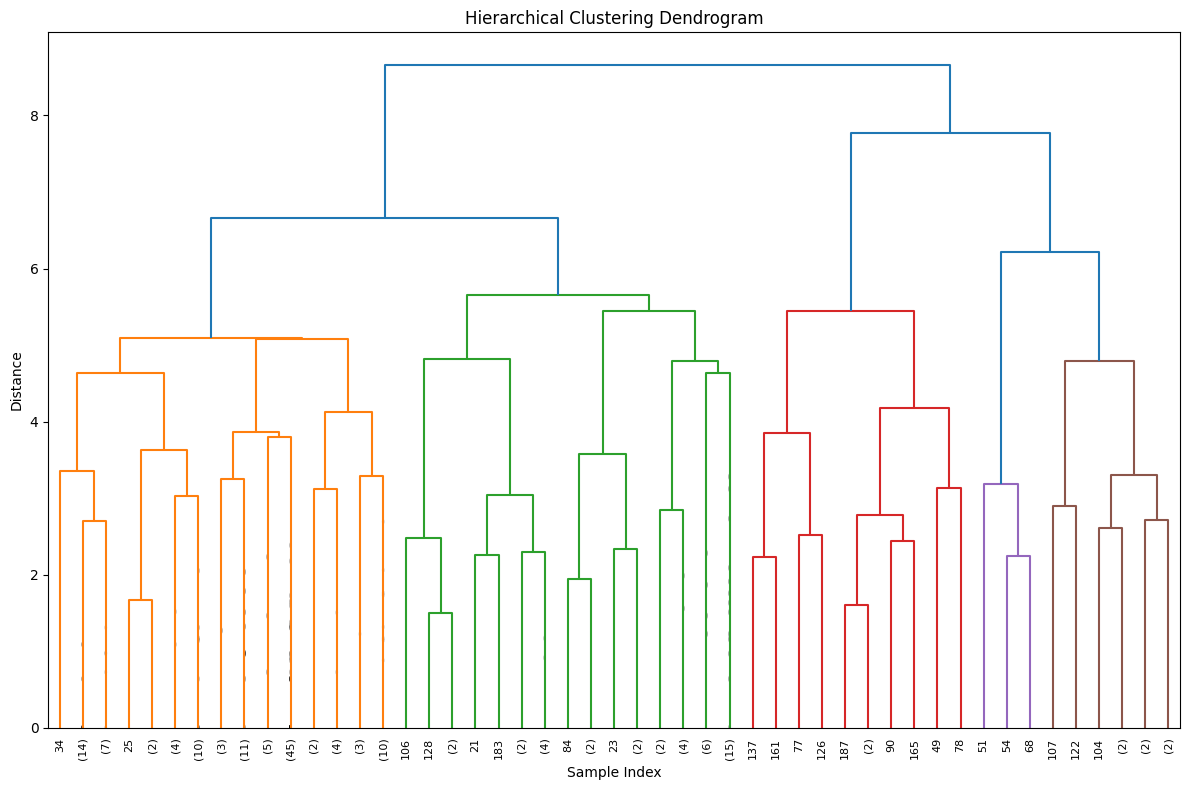

In [61]:
predictors = ["mobility","workplace","pay","marriage","parenthood","entrepreneurship","assets","pension"]

components_df = world_bank_df[predictors]
scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(components_df)
hc_comp_scale = sk.cluster.AgglomerativeClustering(distance_threshold=0,
                       n_clusters=None,
                       linkage='complete').fit(X_scaled)
linkage_comp_scale = compute_linkage(hc_comp_scale)

plt.figure(figsize=(12, 8))
dendrogram(linkage_comp_scale,
          truncate_mode='level',
          p=5,
          leaf_rotation=90.,
          leaf_font_size=8.,
          show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [62]:
hc_comp_scale = sk.cluster.AgglomerativeClustering(distance_threshold=6,
                       n_clusters=None,
                       linkage='complete').fit(X_scaled)
cluster_labels = hc_comp_scale.labels_
cluster_df = pd.DataFrame({
    'country': world_bank_df['country'],
    'iso3': world_bank_df['iso3'],
    "wbl_index": world_bank_df['wbl_index'],
    'cluster': cluster_labels
})

for cluster in sorted(cluster_df['cluster'].unique()):
    countries = cluster_df[cluster_df['cluster'] == cluster][['country', 'wbl_index', 'iso3']].values.tolist()
    print(f"\nCluster {cluster} ({len(countries)} countries):")
    countries = [f"{country} ({wbl_index})" for country, wbl_index, iso3 in countries]
    print(", ".join(countries))


Cluster 0 (45 countries):
Algeria (57.5), Antigua and Barbuda (68.75), Bahrain (68.125), Bangladesh (49.375), Bhutan (75.0), Botswana (63.75), Brunei Darussalam (53.125), Burundi (76.25), Comoros (65.0), Congo, Dem. Rep. (78.75), Djibouti (71.25), Dominica (62.5), Eritrea (69.375), Guinea (73.75), Haiti (61.25), Indonesia (70.625), Jordan (59.375), Kenya (83.75), Kiribati (76.25), Lebanon (58.75), Liberia (81.25), Libya (50.0), Malaysia (60.625), Maldives (73.75), Marshall Islands (65.625), Micronesia, Fed. Sts. (61.25), Morocco (75.625), Nepal (80.625), Nigeria (66.25), Pakistan (58.75), Palau (56.25), Papua New Guinea (60.0), Philippines (78.75), Samoa (75.0), Saudi Arabia (71.25), Solomon Islands (56.875), Somalia (46.875), South Sudan (67.5), St. Vincent and the Grenadines (68.125), Tanzania (81.25), Tonga (58.75), Uganda (83.75), United Arab Emirates (82.5), Vanuatu (55.625), Zambia (81.25)

Cluster 1 (122 countries):
Albania (91.25), Angola (79.375), Argentina (79.375), Armenia 

- Cluster 3 and 4: Majority of African Countries
- Cluster 2: Majority of Muslim countries
- Cluster 1: Countries with higher wbl_index
- Cluster 0: Not specific

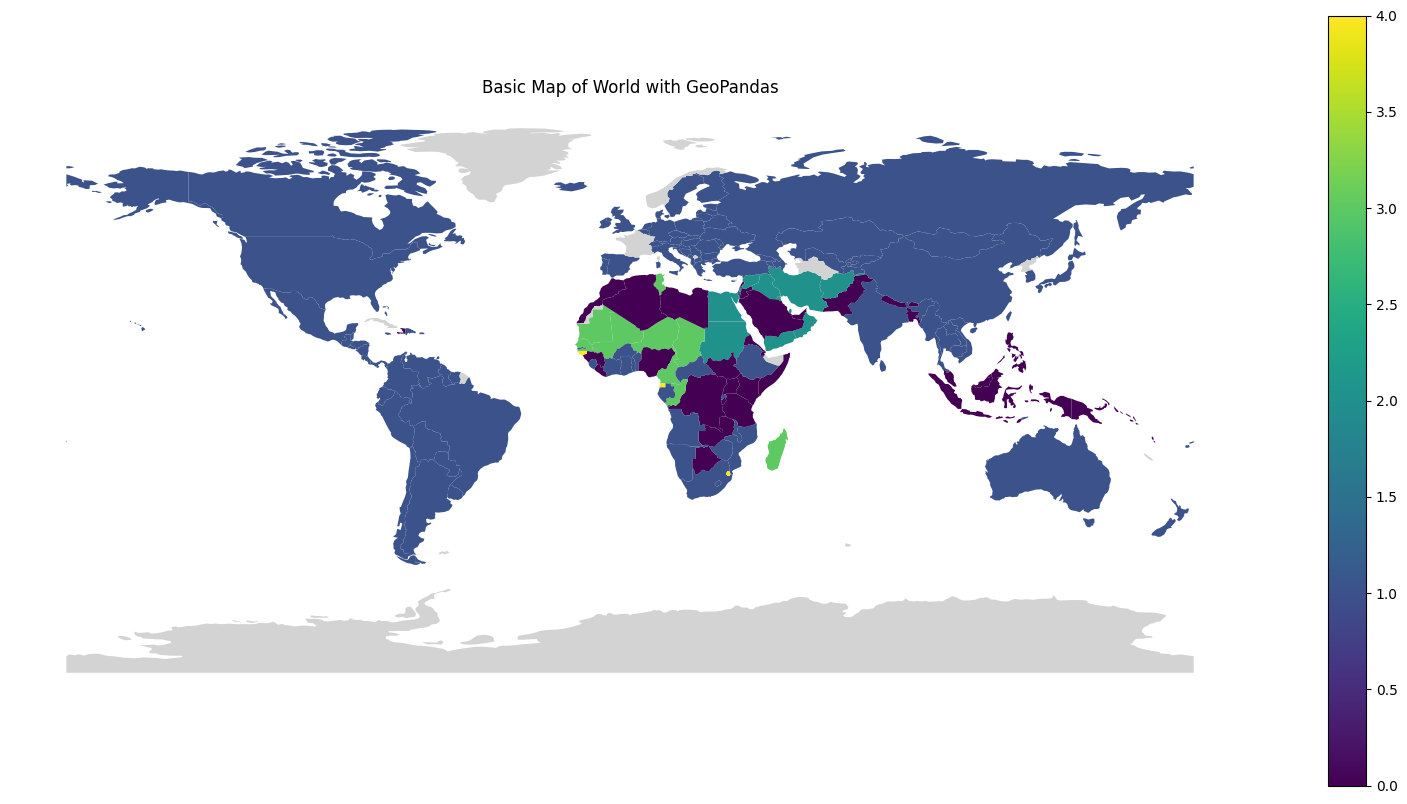

In [63]:
# load the low resolution world map
world = gpd.read_file('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson')
world = world.merge(cluster_df, left_on='ISO_A3', right_on='iso3', how='left')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
world.plot(
    column='cluster',
    ax=ax,
    legend=True,
    missing_kwds={'color': 'lightgrey'}
)

# turn off axis ticks
ax.axis('off')

# set the plot title
plt.title("Basic Map of World with GeoPandas")
plt.show()
